In [1]:
# Input file  

incode= """
l i1 1 0 n0
mod eo1 9000k .18 1 pm n0 n1 

s s1 1 n1 n4

m PRM 0 1 0 n4 n5 # chosen arbitrarily will optimize it 
s lp 1 n5 n6
bs mainbs 0.5 0.5 0 45 n6  n7 n10 n13
s ly 1 n7 n8 
m1 ETMY 5e-06 3.75e-05 0 n8 n9
s lx 1 n10 n11
m1 ETMX 5e-06 3.75e-05 0 n11 n12
s ls 1 n13 n14


#xaxis lx L lin 0 2.128e-6 1000
xaxis ETMX phi lin 0 360 359

# pd0 PIn n4*
# pd0 AfterPRM n5
# pd0 InBS n6*
# pd0 Outy n7
# pd0 Outx n10

# pd0 iny n7*
# pd0 inx n10*
# pd0 ASDC n14

# pd0 Out n14
# pd0 REFLDC n4
# pd0 LeakX n9
# pd0 LeakY n12
#pd1 REFLI 9000k 0 n4
#pd1 REFLQ 9000k 90 n4
#pd1 ASQ 9000k 90 n14
#pd1 ASI 9000k 90 n14
#pd0 IatPRM n5*
#pd0 IatPRM n5*
#pd1 inphase 9000k 0 n1*
#pd1 quadrature 9000k 90 n1*
yaxis abs
"""

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import pykat

import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook
import numpy as np 
# from numpy import arange
HH=12
WW=7
plt.rcParams.update({'font.size': 15})

                                              ..-
    PyKat 1.1.380         _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



# PRMI
## Configuration 

Degrees of freedom 3
1. DARM (Lx-Ly)
2. CARM (Lx+Ly)
3. Lp (Distance of PRM from the BS)


Variables(3)
1. Reflectivity of PRM
2. Lx-Ly(Asymmetry)
3. LP


Available Demodulated Signals (6)
1. ASQ 
2. ASI
3. REFLQ
4. REFLI
5. POPQ
6. POPI



Approach
1. <b>Find the operating point</b>- point where sensitivity for the DARM is highest.<br> 
In order to locate this point we scan the parameter space by varying all the parameters(Rprm and Lx-Ly) and monitor the demodulated signals(ASQ REFLQ POPQ etc) with respect to ETMx tuning. We then calculate the derivative of these signals with respect to ETMx tuning and monitor their maximum value. This is how we generate  a 2d graph containing maximum value of the slope(or sensitivity) of the demodulated signals vs the two parameters.


2. <b>Calculate the sensitivities at the Operating point</b> <br>
we first calculate the sensitivity for the unnormalised DOFs<br>
Lx-Ly:  By keeping Ly fixed and tuning the Lx.<br>
Ly-Lx: By keeping Lx fixed and tuning Ly.<br>
we then calculate the sensitivity for DARM and CARM by adding and subtracting the two sensitivities.

![Image not found](config.png "Title")

# Choosing the operating Point
At the operating point the sensitivity of the interferometer for the DARM should be highest.<br>

Trying the initial configuration:<br>
In this configuration the interferometer is at the Balanced point (Lx=Ly) and Power recycling mirror is absent (Rprm=0) 
<br>
The plot of Demodulated signals with respect to tuning of ETMX is shown below . The maximum value of the signal is around 1e-8.

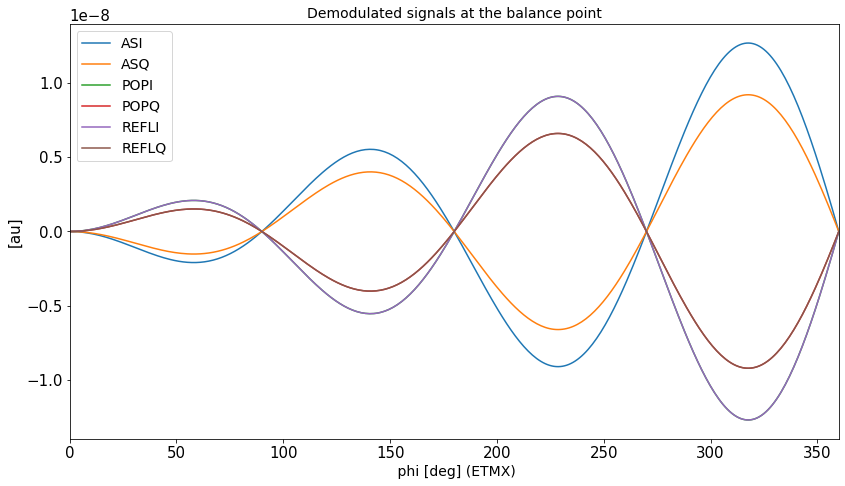

In [3]:
ob = pykat.finesse.kat()
ob.verbose = False
ob.parse(incode)
ob.parse("""pd1 ASQ 9000k 90 n14
pd1 ASI 9000k 0 n14
pd1 POPI 9000k 0 n5*
pd1 POPQ 9000k 90 n5*
pd1 REFLI 9000k 0 n4
pd1 REFLQ 9000k 90 n4
""")
# ob.PRM.R=0
# ob.PRM.T=1-ob.PRM.R
res=ob.run()
plt.rcParams['figure.figsize'] = [HH,WW]
fig = res.plot(title='Demodulated signals at the balance point')

plt.show()

# Optimization :Maximising sensitivity#
 
We have to find other possible states of the interferometer where it is most sensitive for DARM.  
In order to achieve that lets vary the Lx-Ly from 0 to $\lambda_{mod}$ and plot the maximum value of the three demodulated signals(ASQ REFQ POPQ) and see if the value can be maximized.

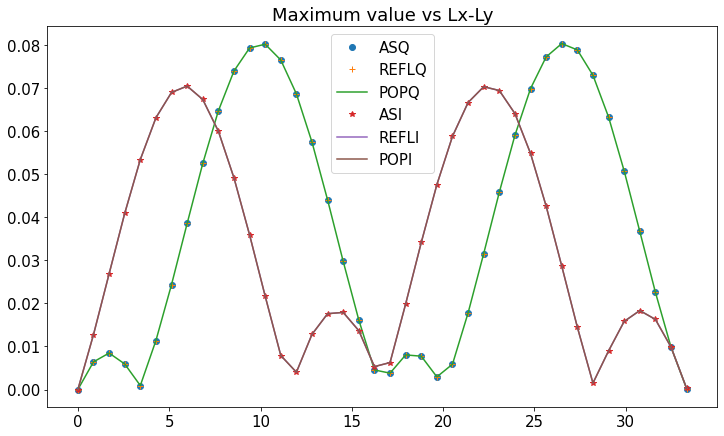

In [4]:
ob = pykat.finesse.kat()
ob.verbose = False
ob.parse(incode)
ob.parse("""pd1 ASQ 9000k 90 n14
pd1 ASI 9000k 0 n14
pd1 POPI 9000k 0 n5*
pd1 POPQ 9000k 90 n5*
pd1 REFLI 9000k 0 n4
pd1 REFLQ 9000k 90 n4
""")

# ob.ly.L=1
# ob.lx.L=1
ob.PRM.R=0
ob.PRM.T=1
n=40

dlmax=33.33
dl=np.zeros(n)
Maxasq=np.zeros(n)
Maxreflq=np.zeros(n)
Maxpopq=np.zeros(n)

Maxasi=np.zeros(n)
Maxrefli=np.zeros(n)
Maxpopi=np.zeros(n)

for i in range(n):
    dli=i*((dlmax)/(n-1))
    ob.lx.L=dli+1
#     print(ob.lx.L)
    res=ob.run()
    dl[i]=dli
    Maxasq[i]=max(res["ASQ"])
    Maxreflq[i]=max(res["REFLQ"])
    Maxpopq[i]=max(res["POPQ"])
    Maxasi[i]=max(res["ASI"])
    Maxrefli[i]=max(res["REFLI"])
    Maxpopi[i]=max(res["POPI"])
    



plt.plot(dl,Maxasq,'o',label='ASQ' )
plt.plot(dl,Maxreflq,'+',label='REFLQ')
plt.plot(dl,Maxpopq,'-',label='POPQ')
plt.plot(dl,Maxasi,'*',label='ASI')
plt.plot(dl, Maxrefli,label='REFLI')
plt.plot(dl, Maxpopi,label='POPI')


plt.legend()
plt.title("Maximum value vs Lx-Ly")
plt.rcParams['figure.figsize'] = [HH,WW]
plt.show()


In this plot we see that:<br> 
1. The In-phase signals(ASI, REFLI, POPI) have the maximum value of about 0.07 at Lx-Ly=6.2.
2. The Quadrature signals(ASQ, REFLQ, POPQ) have the maximum value of about 0.08 at at Lx-Ly=10.2.

Choosing this value of Lx-Ly=10.24 and plotting the Quadrature signals with ETMX tuning.  

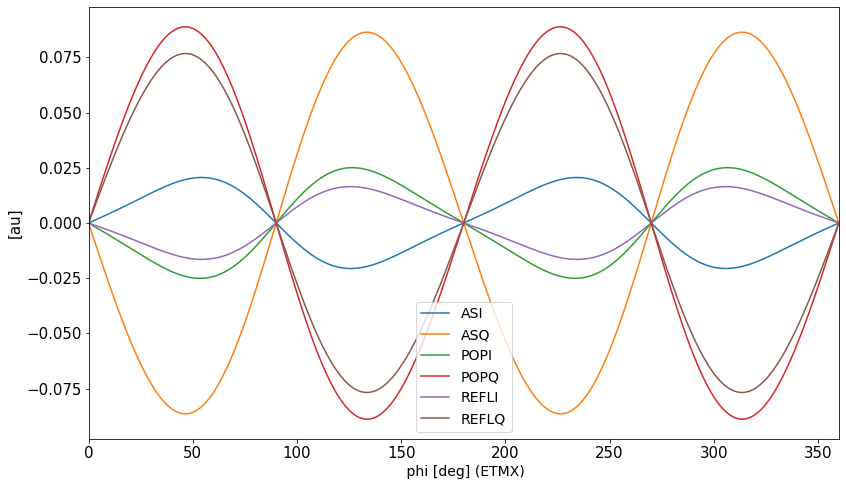

In [5]:
ob = pykat.finesse.kat()
ob.verbose = False
ob.parse(incode)
ob.parse("""pd1 ASQ 9000k 90 n14
pd1 ASI 9000k 0 n14
pd1 POPI 9000k 0 n5*
pd1 POPQ 9000k 90 n5*
pd1 REFLI 9000k 0 n4
pd1 REFLQ 9000k 90 n4
""")


ob.ly.L=1
ob.lx.L=11.203061224489796
ob.PRM.R=0.01
ob.PRM.T=1-ob.PRM.R
res=ob.run()
fig = res.plot()
plt.rcParams['figure.figsize'] = [HH,WW]
plt.show()

# Simultaneous optimization# 
In order to optimize fully we have to vary both variables(Rprm and Lx-Ly) simultaneously. We vary Rprm from 0 to 1 and Lx-Ly 0 to 𝜆𝑚𝑜𝑑 and monitor the maximum value of the sensitivity of demodulated signals.


In [21]:
ob = pykat.finesse.kat()
ob.verbose = False
ob.parse(incode)
ob.parse("""pd1 ASQ 9000k 90 n14
pd1 ASI 9000k 0 n14
pd1 POPI 9000k 0 n5*
pd1 POPQ 9000k 90 n5*
pd1 REFLI 9000k 0 n4
pd1 REFLQ 9000k 90 n4
""")

# ob.ly.L=1
# ob.lx.L=1
n=10
dlmax=33.33
rmax=1
dl=np.zeros(n)
ref=np.linspace(0,rmax,n)
dl=np.linspace(0,dlmax,n)

REFLECTIVITY, DL = np.meshgrid(ref,dl)



Maxasq=np.zeros((n,n,n))
Maxreflq=np.zeros((n,n,n))
Maxpopq=np.zeros((n,n,n))
maxasq2=np.zeros((n,n))
maxreflq2=np.zeros((n,n))
maxpopq2=np.zeros((n,n))


for j in range(n):
    r=j*((rmax)/(n-1))
    ob.PRM.R=r
    ob.PRM.T=1-r
    print("r",r)
    for i in range(n):
        dli=i*((dlmax)/(n-1))
        ob.lx.L=dli+1
    #     print(ob.lx.L)
        

        for p in range(n):
            dlp=p*((dlmax)/(n-1))
            ob.lp.L=dlp+1
            res=ob.run()
        
            Maxasq[i][j][p]=max(np.abs(np.diff(res["ASQ"])))
            Maxreflq[i][j][p]=max(np.abs(np.diff(res["REFLQ"])))
            Maxpopq[i][j][p]=max(np.abs(np.diff(res["POPQ"])))
        maxasq2[i][j]=max(Maxasq[i][j][:])
        maxreflq2[i][j]=max(Maxreflq[i][j][:])
        maxpopq2[i][j]=max(Maxpopq[i][j][:])



popqm=np.amax(Maxpopq)
imax,jmax,pmax=np.where(Maxpopq==np.amax(Maxpopq))
print(imax*((dlmax)/(n-1)))
print(jmax*((rmax)/(n-1)))
print(pmax*((dlmax)/(n-1)))
print("Max sensitivity of POPQ is =", popqm, "at Lx-Ly=",imax*((dlmax)/(n-1)) ,'Rprm=',jmax*((rmax)/(n-1)), "Lp=",pmax*((dlmax)/(n-1)))

# print(len(dl))
# print(len(Maxasq))
# print(dl)

# hjhj
fig = plt.figure()
ax = fig.gca(projection='3d')
plt.title('Max value of ASQ sensitivity vs Rprm and Lx-Ly ')
surf = ax.plot_surface(DL,REFLECTIVITY,maxasq2)
ax.set_xlabel('Lx-Ly')
ax.set_ylabel('Rprm')
ax.set_zlabel('Max value of ASQ sensitivity')
# plt.rcParams['figure.figsize'] = [HH,WW]
plt.show()

fig = plt.figure()
ax = fig.gca(projection='3d')
plt.title('Max value of REFLQ sensitivity vs Rprm and Lx-Ly ')
surf = ax.plot_surface(DL,REFLECTIVITY,maxreflq2)
ax.set_xlabel('Lx-Ly')
ax.set_ylabel('Rprm')
ax.set_zlabel('Max value of REFLQ sensitivity ')
plt.rcParams['figure.figsize'] = [HH,WW]
plt.show()


fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(DL,REFLECTIVITY,maxpopq2)
plt.title('Max value of POPQ sensitivity vs Rprm and Lx-Ly ')
ax.set_xlabel('Lx-Ly')
ax.set_ylabel('Rprm')
ax.set_zlabel('Max value of POPQ sensitivity')
plt.rcParams['figure.figsize'] = [HH,WW]
plt.show()


r 0.0
r 0.1111111111111111


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.




--------------------------------------------------------------
Error from Finesse (See 'pykat.lastErrorKat' for kat object):
  
Error:   Failed to make connection on named pipe.
Error=535
--------------------------------------------------------------

Traceback (most recent call last):
  File "d:\users\w\appdata\local\programs\python\python38\lib\site-packages\pykat\finesse.py", line 2260, in run
    raise pkex.FinesseRunError(r.stderr, katfile.name)
pykat.exceptions.FinesseRunError: 
*** Error: 
Failed to make connection on named pipe. Error=535

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "d:\users\w\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-dbf00dc59306>", line 47, in <module>
    res=ob.run()
  File "d:\users\w\appdata\local\programs\python\python38\lib\site-packag

SystemExit: 1

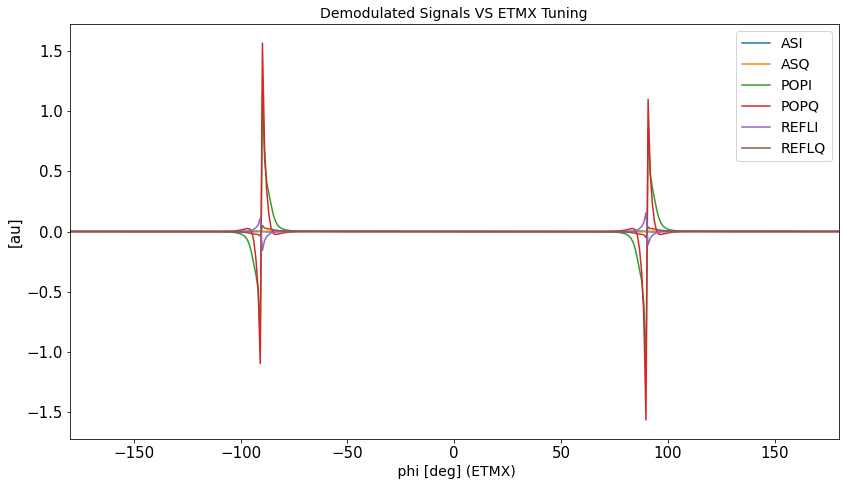

In [7]:
ob = pykat.finesse.kat()
ob.verbose = False
ob.parse(incode)
ob.parse("""pd1 ASQ 9000k 90 n14
pd1 ASI 9000k 0 n14
pd1 POPI 9000k 0 n5*
pd1 POPQ 9000k 90 n5*
pd1 REFLI 9000k 0 n4
pd1 REFLQ 9000k 90 n4
xaxis ETMX phi lin -180 180 359
""")

ob.lp.L=14.81
ob.ly.L=1
ob.lx.L=18.94
ob.PRM.R=.9894
ob.PRM.T=1-ob.PRM.R
res=ob.run()
fig = res.plot(title='Demodulated Signals VS ETMX Tuning')
plt.rcParams['figure.figsize'] = [HH,WW]

# plt.show()

## Choosing the operating Point 
As can be seen from the graph. Maximum values of the sensitivity for different signals are given below<br> 

ASQ has maximum value of 0.12 at Lx-Ly=12.1(also at 29.6)  and R=0.89<br>
REFLQ has maximum value of 0.019 at Lx-Ly=11   and R=0.89<br>
POPQ has maximum value of at 0.35 Lx-Ly=14.76 and R=0.89<br>
<I> Zooming in the region by making the grid fine, reveals that the maximum sensitivity of POPQ occurs at (Lx-Ly=13.76 and R=0.9915)</I>
  


The maximum value of the sensitivity first increases with r and then decreases with r. There is an optimum value of r for which the sensitivity is maximum.

The maximum value for sensitivity of the POPQ is very large compared to other two therefore choosing (Lx-Ly=13.76 and R=0.9915) as our operating point.

# Sensing matrix
It is obtained by calculating the slope of error signals at the operating point 

## Calculating error signals at the operating point
At the operating point we vary each of the DOFs (Degree of freedom) one by one and monitor the value of the demodulated signals.
## 1. Keeping Ly fixed and moving Lx

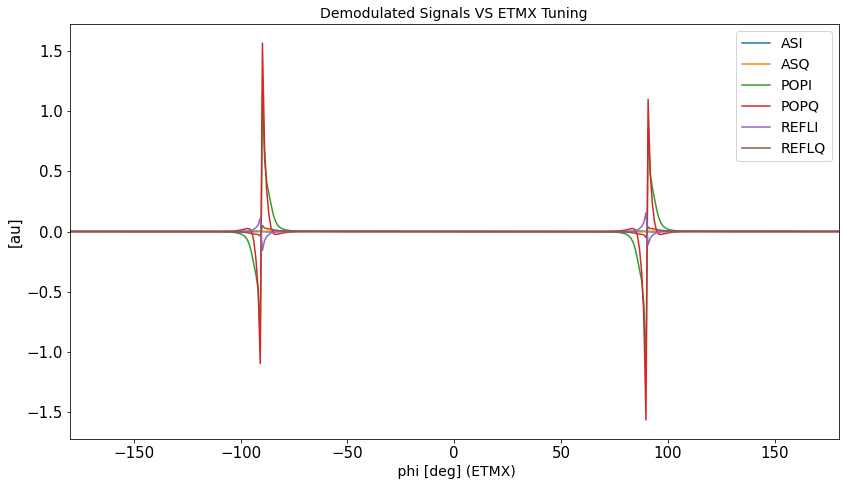

In [8]:
ob = pykat.finesse.kat()
ob.verbose = False
ob.parse(incode)
ob.parse("""pd1 ASQ 9000k 90 n14
pd1 ASI 9000k 0 n14
pd1 POPI 9000k 0 n5*
pd1 POPQ 9000k 90 n5*
pd1 REFLI 9000k 0 n4
pd1 REFLQ 9000k 90 n4
xaxis ETMX phi lin -180 180 359
""")


ob.lp.L=14.81
ob.ly.L=1
ob.lx.L=18.94
ob.PRM.R=.9894
ob.PRM.T=1-ob.PRM.R
res=ob.run()
fig = res.plot(title='Demodulated Signals VS ETMX Tuning')
plt.rcParams['figure.figsize'] = [HH,WW]

# plt.show()

### Zoomed in around phi=90
#### Operating point is taken to be Lx-Ly=13.76 , Rprm=0.9915, ETMx Phi=90

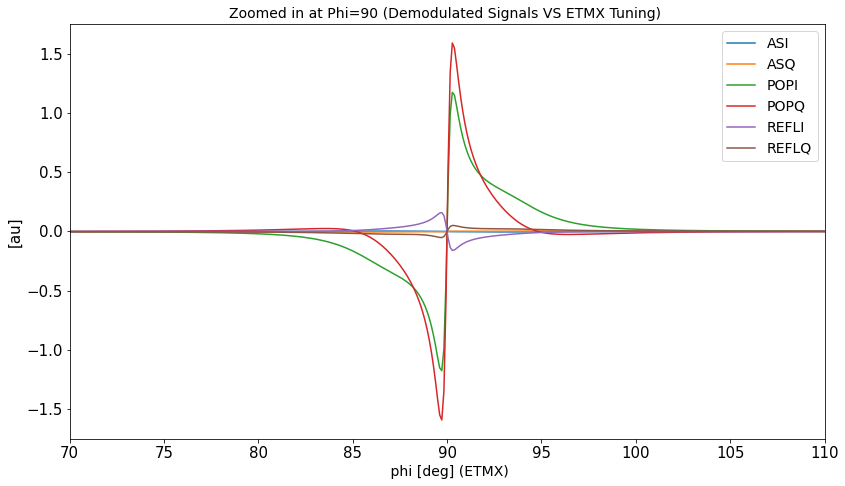

In [9]:
ob = pykat.finesse.kat()
ob.verbose = False
ob.parse(incode)
ob.parse("""pd1 ASQ 9000k 90 n14
pd1 ASI 9000k 0 n14
pd1 POPI 9000k 0 n5*
pd1 POPQ 9000k 90 n5*
pd1 REFLI 9000k 0 n4
pd1 REFLQ 9000k 90 n4
xaxis ETMX phi lin 70 110 359
""")


ob.lp.L=14.81
ob.ly.L=1
ob.lx.L=18.94
ob.PRM.R=.9894
ob.PRM.T=1-ob.PRM.R
res=ob.run()
fig = res.plot(title='Zoomed in at Phi=90 (Demodulated Signals VS ETMX Tuning) ')
plt.rcParams['figure.figsize'] = [HH,WW]

### Calculating the slopes of the signals at the operating point.

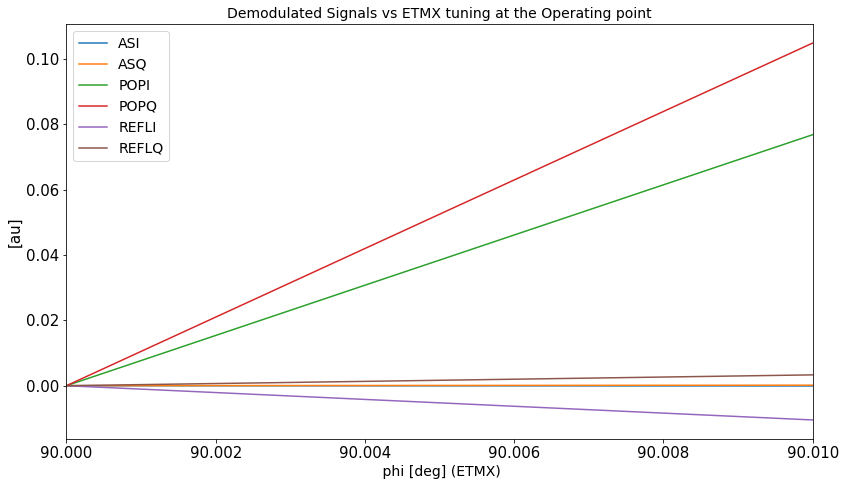

Slopes= [ 1.61e-04 -7.86e-05  1.05e-01  7.68e-02  3.31e-03 -1.05e-02]


In [10]:
ob = pykat.finesse.kat()
ob.verbose = False
ob.parse(incode)
ob.parse("""pd1 ASQ 9000k 90 n14
pd1 ASI 9000k 0 n14
pd1 POPI 9000k 0 n5*
pd1 POPQ 9000k 90 n5*
pd1 REFLI 9000k 0 n4
pd1 REFLQ 9000k 90 n4
xaxis ETMX phi lin 90 90.01 10
""")


ob.lp.L=14.81
ob.ly.L=1
ob.lx.L=18.94
ob.PRM.R=.9894
ob.PRM.T=1-ob.PRM.R
res=ob.run()
Sasq=res["ASQ"][-1]
Sasi=res["ASI"][-1]
Spopq=res["POPQ"][-1]
Spop=res["POPI"][-1]
Sreflq=res["REFLQ"][-1]
Srefli=res["REFLI"][-1]
# print(Sasq,Sasi,Spopq,Spop,Sreflq,Srefli)
# print('|',round(Sasq,4),'|',round(Sasi,4),'|',round(Spopq,4),'|',round(Spop,4),'|',round(Sreflq,4),'|',round(Srefli,4),'|')
# plt.figure(1)
np.set_printoptions(precision=2)
sx=np.array([Sasq,Sasi,Spopq,Spop,Sreflq,Srefli])
fig = res.plot(title="Demodulated Signals vs ETMX tuning at the Operating point")
print("Slopes=",sx)

## 2. Keeping Lx fixed and moving Ly

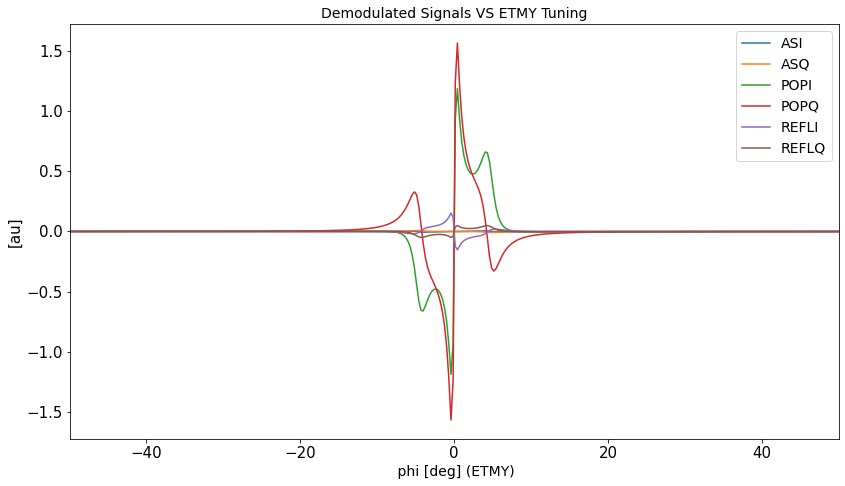

In [11]:
ob = pykat.finesse.kat()
ob.verbose = False
ob.parse(incode)
ob.parse("""pd1 ASQ 9000k 90 n14
pd1 ASI 9000k 0 n14
pd1 POPI 9000k 0 n5*
pd1 POPQ 9000k 90 n5*
pd1 REFLI 9000k 0 n4
pd1 REFLQ 9000k 90 n4
xaxis ETMY phi lin -50 50 359
""")

ob.ETMX.phi=90
ob.lp.L=14.81
ob.ly.L=1
ob.lx.L=18.94
ob.PRM.R=.9894
ob.PRM.T=1-ob.PRM.R
res=ob.run()
fig = res.plot(title='Demodulated Signals VS ETMY Tuning')


# plt.show()

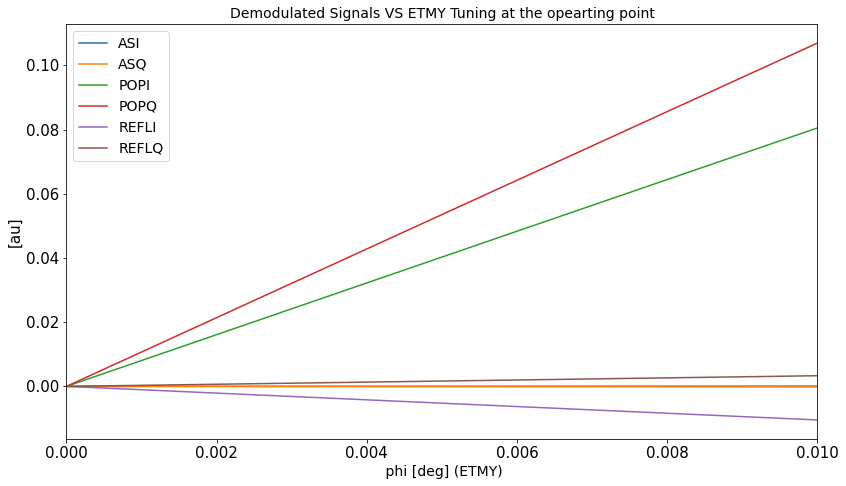

[-1.61e-04  7.86e-05  1.07e-01  8.05e-02  3.32e-03 -1.05e-02]


In [12]:
ob = pykat.finesse.kat()
ob.verbose = False
ob.parse(incode)
ob.parse("""pd1 ASQ 9000k 90 n14
pd1 ASI 9000k 0 n14
pd1 POPI 9000k 0 n5*
pd1 POPQ 9000k 90 n5*
pd1 REFLI 9000k 0 n4
pd1 REFLQ 9000k 90 n4
xaxis ETMY phi lin 0 0.01 10
""")

ob.ETMX.phi=90
ob.lp.L=14.81
ob.ly.L=1
ob.lx.L=18.94
ob.PRM.R=.9894
ob.PRM.T=1-ob.PRM.R
res=ob.run()
Sasq=res["ASQ"][-1]
Sasi=res["ASI"][-1]
Spopq=res["POPQ"][-1]
Spop=res["POPI"][-1]
Sreflq=res["REFLQ"][-1]
Srefli=res["REFLI"][-1]
# print(Sasq,Sasi,Spopq,Spop,Sreflq,Srefli)
# print('|',round(Sasq,4),'|',round(Sasi,4),'|',round(Spopq,4),'|',round(Spop,4),'|',round(Sreflq,4),'|',round(Srefli,4),'|')
# sy=[Sasq,Sasi,Spopq,Spop,Sreflq,Srefli]
sy=np.array([Sasq,Sasi,Spopq,Spop,Sreflq,Srefli])


fig = res.plot(title='Demodulated Signals VS ETMY Tuning at the opearting point')
print(sy)

# plt.show()

## 3. Keeping Lx , Ly fixed and moving the PRM Mirror

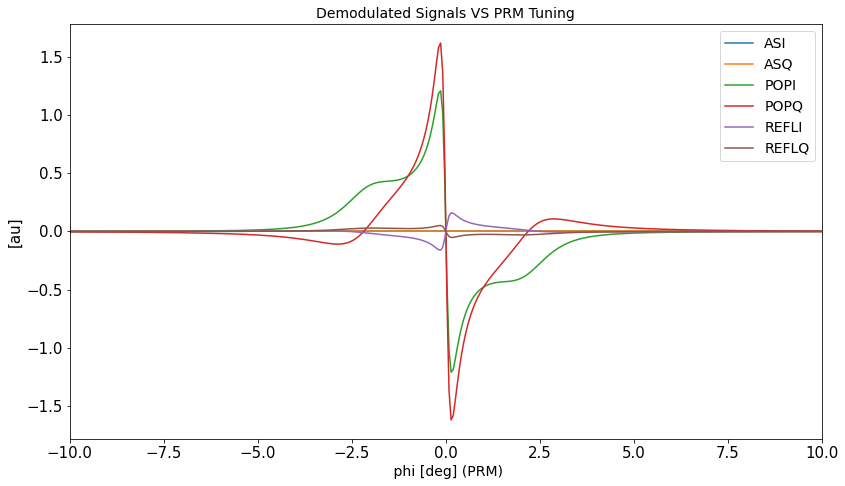

In [13]:
ob = pykat.finesse.kat()
ob.verbose = False
ob.parse(incode)
ob.parse("""pd1 ASQ 9000k 90 n14
pd1 ASI 9000k 0 n14
pd1 POPI 9000k 0 n5*
pd1 POPQ 9000k 90 n5*
pd1 REFLI 9000k 0 n4
pd1 REFLQ 9000k 90 n4
#xaxis ETMX phi lin -180 180 359
xaxis PRM phi lin -10 10 359
""")

ob.ETMX.phi=90
ob.lp.L=14.81
ob.ly.L=1
ob.lx.L=18.94
ob.PRM.R=.9894

ob.PRM.T=1-ob.PRM.R
res=ob.run()
fig = res.plot(title='Demodulated Signals VS PRM Tuning')


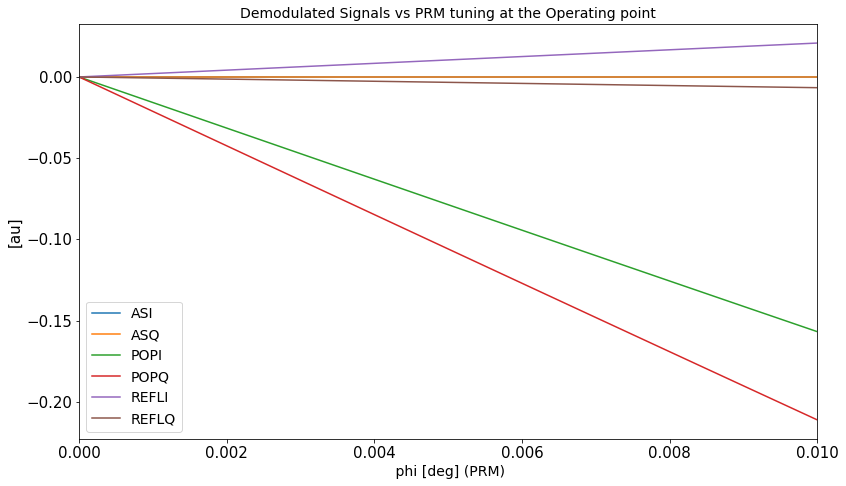

| Lx-Ly |1.61e-04 | -7.86e-05 | 1.05e-01 | 7.68e-02 | 3.31e-03 | -1.05e-02 | 
| Ly-Lx |-1.61e-04 | 7.86e-05 | 1.07e-01 | 8.05e-02 | 3.32e-03 | -1.05e-02 | 
| CARM |1.61e-04 | -7.86e-05 | -1.08e-03 | -1.87e-03 | -5.73e-06 | -9.91e-06 | 
| DARM |1.25e-09 | -3.55e-09 | 1.06e-01 | 7.87e-02 | 3.32e-03 | -1.05e-02 | 
| Lp |-6.05e-17 | 2.96e-17 | -2.11e-01 | -1.57e-01 | -6.61e-03 | 2.09e-02 | 

In [14]:
ob = pykat.finesse.kat()
ob.verbose = False
ob.parse(incode)
ob.parse("""pd1 ASQ 9000k 90 n14
pd1 ASI 9000k 0 n14
pd1 POPI 9000k 0 n5*
pd1 POPQ 9000k 90 n5*
pd1 REFLI 9000k 0 n4
pd1 REFLQ 9000k 90 n4
#xaxis ETMX phi lin -180 180 359
xaxis PRM phi lin 0 0.01 10
""")

ob.ETMX.phi=90
ob.lp.L=14.81
ob.ly.L=1
ob.lx.L=18.94
ob.PRM.R=.9894
ob.PRM.T=1-ob.PRM.R
res=ob.run()
Sasq=res["ASQ"][-1]
Sasi=res["ASI"][-1]
Spopq=res["POPQ"][-1]
Spop=res["POPI"][-1]
Sreflq=res["REFLQ"][-1]
Srefli=res["REFLI"][-1]
# print(Sasq,Sasi,Spopq,Spop,Sreflq,Srefli)

# print('|',round(Sasq,4),'|',round(Sasi,4),'|',round(Spopq,4),'|',round(Spop,4),'|',round(Sreflq,4),'|',round(Srefli,4),'|')
sp=np.array([Sasq,Sasi,Spopq,Spop,Sreflq,Srefli])
fig = res.plot(title='Demodulated Signals vs PRM tuning at the Operating point')
# plt.title('')
# plt.show()
# print("Lx-Ly",sx)
# print("Ly-Lx",sy)
# print("carm",(sx-sy)/2)
# print("darm",(sx+sy)/2)
# print("Lp",sp)

#for printing Sensity matrix
np.set_printoptions(precision=2)
print("| Lx-Ly |",end='')
for i in range(6): 
    print("{:.2e}".format(sx[i]),'| ',end='')
print('')    
print("| Ly-Lx |",end='')
for i in range(6): 
    print("{:.2e}".format(sy[i]),'| ',end='')
    
print('')
print("| CARM |",end='')

for i in range(6): 
    print("{:.2e}".format((sx[i]-sy[i])/2),'| ',end='')    
    
print('')
print("| DARM |",end='')
for i in range(6): 
    print("{:.2e}".format((sx[i]+sy[i])/2),'| ',end='')      
print('')   
print("| Lp |",end='')
for i in range(6): 
    print("{:.2e}".format(sp[i]),'| ',end='')  




Sensing Matrix <br>
Units are watt per 10milli degree($\lambda$/36000) .

|       | ASQ    | ASI     | POPQ   | POPI  | REFLQ  | REFLI  |
|-------|--------|---------|--------|-------|--------|--------|
| Lx-Ly |4.00e-04 | 1.06e-03 | <b>-3.97e-01 <b>| 1.53e-01 | 1.96e-02 | -1.19e-01 | 
| Ly-Lx |-4.68e-05 | -1.23e-04 |<b> -4.67e-02 <b>| 1.88e-02 | 2.28e-03 | -1.39e-02 | 
| CARM |2.24e-04 | 5.91e-04 | <b>-1.75e-01<b> | 6.73e-02 | 8.67e-03 | -5.28e-02 | 
| DARM |1.77e-04 | 4.69e-04 | <b>-2.22e-01<b> | 8.62e-02 | 1.10e-02 | -6.67e-02 | 
| Lp |-1.58e-17 | -4.15e-17 | <b>9.24e-02<b> | -3.65e-02 | -4.55e-03 | 2.77e-02 | 

<br>
Sensitivity for DARM and CARM can be obtained by adding and subtracting the two sensitivities.